In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow.keras import backend as K

K.set_floatx('float64')

from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Layer, Add, Multiply
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.initializers import RandomUniform, Constant

from tf_extensions.tf_custom.layers  import MixingBlock, Snake
from tf_extensions.tf_custom.metrics import CoefficientOfDetermination
from tf_extensions.tf_custom.losses  import SpectralPhaseLogProbLoss, SpectralAmplitudeLogProbLoss
from tf_extensions.tf_custom.losses  import SpectralPhaseLoss
from tf_extensions.tf_util import TF_PI, interp_loss_weight, tf_vonmises_log_prob

#### Load the spectral audio data 

In [2]:
import joblib

_PATHS_TO_AUDIO_DATA = [
    "./dance_wav/audio_spectral_data_synth.pkl",
    "./dance_wav/audio_spectral_data_simon.pkl"
    #"./dance_wav/audio_spectral_data.pkl"
]

#_PATH_TO_AUDIO_DATA    = "./dance_wav/audio_spectral_data_synth.pkl"
metas = []
normalized_power_spectrum = []
normalized_phase_spectrum = []
for path_ in _PATHS_TO_AUDIO_DATA:
    spectral_audio_dataset = joblib.load(path_)
    spectral_data = spectral_audio_dataset["Data"]
    normalized_power_spectrum.append(spectral_data["NormalizedFFTMagnitudes"])
    normalized_phase_spectrum.append(spectral_data["NormalizedFFTPhases"])
    #normalized_power_spectrum =\
    #    spectral_data["NormalizedFFTMagnitudes"]
    #normalized_phase_spectrum =\
    #    spectral_data["NormalizedFFTPhases"]
    metas.append(spectral_audio_dataset["MetaInfo"])

normalized_power_spectrum = np.concatenate(normalized_power_spectrum, axis=0) #.reshape(-1, 513)
normalized_phase_spectrum = np.concatenate(normalized_phase_spectrum, axis=0) #.reshape(-1, 513)
print(normalized_power_spectrum.shape, normalized_phase_spectrum.shape)

(40828, 513) (40828, 513)


In [3]:
meta_data = metas[0]
SR        = meta_data["SampleRate"]
DUR       = meta_data["ClipDuration"]
DBREF     = meta_data["DB_ref"]
OVERLAP   = meta_data["Overlap"]
NFFT      = meta_data["Num_fft"]
FFTWIN    = meta_data["FFTWindow"]

win_samps = scipy.signal.get_window(FFTWIN, NFFT, fftbins=True)
WINSUM    = np.sum(win_samps)

with tf.name_scope("audio_meta"):
    TF_DBREF  = tf.constant(DBREF,  dtype=K.floatx(), name="db_ref")
    TF_WINSUM = tf.constant(WINSUM, dtype=K.floatx(), name="winsum")

#### Create time-distributed inputs 

In [4]:
print("{0} {1} {2} {3}".format(
    normalized_power_spectrum.shape, normalized_power_spectrum.dtype, 
    normalized_phase_spectrum.shape, normalized_phase_spectrum.dtype
))

print("[{0:.4f} {1:.4f}], [{2:.4f} {3:.4f}]".format(
    normalized_power_spectrum.min(), normalized_power_spectrum.max(), 
    normalized_phase_spectrum.min(), normalized_phase_spectrum.max()
))

(40828, 513) float64 (40828, 513) float64
[-1.0000 1.0018], [-1.0000 1.0000]


####  Extract training and validation data

In [5]:
from sklearn.model_selection import train_test_split

tsize = 0.05
state = 9

arr = np.stack([
    normalized_power_spectrum,
    normalized_phase_spectrum
], axis=-1)
X_train, X_test = train_test_split(
    arr, test_size=tsize, random_state=state
)
print(X_train.shape, X_test.shape)

# Get the magnitude spectrograms
mag_train = tf.convert_to_tensor(
    X_train[:, :, 0], dtype=tf.float64
)
mag_test  = tf.convert_to_tensor(
    X_test[:, :, 0], dtype=tf.float64 
)
print(normalized_power_spectrum.shape)
print(mag_train.shape, mag_test.shape)

phase_train = tf.convert_to_tensor(
    X_train[:, :, 1], dtype=tf.float64
)
phase_test  = tf.convert_to_tensor(
    X_test[:, :, 1], dtype=tf.float64
)
print(normalized_phase_spectrum.shape)
print(phase_train.shape, phase_test.shape)

(38786, 513, 2) (2042, 513, 2)
(40828, 513)
(38786, 513) (2042, 513)
(40828, 513)
(38786, 513) (2042, 513)


In [6]:
# Test loss classes
def phase_inv_callback(x):
    return x * TF_PI

def tf_inverse_normalize_db(S_n_db):
    return S_n_db * TF_DBREF - TF_DBREF 

def tf_db_to_power(S_db):
    tf_ten = tf.cast(10., dtype=K.floatx())
    return tf.math.pow(tf_ten, .1 * S_db)

def tf_normalized_db_to_amp(S_n_db):
    S_db = tf_inverse_normalize_db(S_n_db)
    S = tf_db_to_power(S_db)
    S = (S * TF_WINSUM) * .5
    return S 

def ampli_inv_callback(x):
    return tf_normalized_db_to_amp(x)

In [7]:
def gaussian_log_prob(z, mu, logvar):
    return -0.5*(tf.math.log(2.0*TF_PI) + logvar + tf.math.pow((z-mu), 2.0)/tf.math.exp(logvar))

def log_mean_exp(x, axis):
    m  = tf.math.reduce_max(x, axis=axis)
    m2 = tf.math.reduce_max(x, axis=axis, keepdims=True)
    return m + K.log(K.mean(K.exp(x-m2), axis))

def make_encoder(input_dim, im_dim, latent_dim):
    input_nn_0 = Input(shape=(input_dim, ))    
    input_nn_1 = Input(shape=(input_dim, ))
    
    added, k = MixingBlock(mix_type="lerp")([input_nn_0, input_nn_1]) #tf.keras.layers.Add()([input_nn_0, input_nn_1])
    
    dense_0 = WeightNormalization(Dense(513))(added)
    dense_0 = Snake(trainable=True)(dense_0)
    dense_0 = WeightNormalization(Dense(256))(dense_0)
    dense_0 = Snake(trainable=True)(dense_0)
    dense_0 = WeightNormalization(Dense(128))(dense_0)
    dense_0 = Snake(trainable=True)(dense_0)
    encoder_dense = Dense(
        2*latent_dim, name="encoder",
        kernel_initializer="zeros", bias_initializer='zeros'
    )(dense_0)
    return Model(inputs=[input_nn_0, input_nn_1], outputs=[encoder_dense])

def make_decoder(input_dim, im_dim, latent_dim):
    input_nn = Input(shape=(latent_dim, ))
    dense_0 = WeightNormalization(Dense(513))(input_nn)
    dense_0 = Snake(trainable=True)(dense_0)
    dense_0 = WeightNormalization(Dense(513))(dense_0)
    dense_0 = Snake(trainable=True)(dense_0)
    dense_0 = WeightNormalization(Dense(513))(dense_0)
    dense_0 = Snake(trainable=True)(dense_0)
    decoder_linear_0 = Dense(2*input_dim, name="decoder_out_0")(dense_0)
    decoder_linear_0 = Snake(trainable=True)(decoder_linear_0)
    decoder_linear_1 = Dense(2*input_dim, name="decoder_out_1")(dense_0)
    decoder_linear_1 = Snake(trainable=True)(decoder_linear_1)
    return Model(inputs=input_nn, outputs=[decoder_linear_0, decoder_linear_1])
    
class TestModel(Model):
    
    def __init__(self, input_dim, im_dim=513, latent_dim=513, *args, **kwargs):
        super(TestModel, self).__init__(*args, **kwargs)
        self.custom_optimizer = None
        self.r = tf.constant(0.0026, dtype=K.floatx())
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.im_dim = im_dim
        self.encoder = make_encoder(input_dim, im_dim, latent_dim)
        self.decoder = make_decoder(input_dim, im_dim, latent_dim)
    
    def custom_compile(self, optimizer):
        # Optimizer is parsed from call to ´custom_compile´
        self.custom_optimizer = optimizer
        
        # Define metric function
        #self.r2_score = CoefficientOfDetermination()
        
        # Define some metric data displays
        self.loss_ph  = tf.keras.metrics.Mean(name="ELBO")
        self.reg_loss = tf.keras.metrics.Mean(name="reg")
        self.rec_loss = tf.keras.metrics.Mean(name="rec")
        #self.rec_1_loss = tf.keras.metrics.Mean(name="rec_1")
        super(TestModel, self).compile()
    
    @property
    def metrics(self):
        _metrics = [
            self.loss_ph,
            self.reg_loss,
            self.rec_loss
            #self.rec_1_loss
        ]
        return _metrics
    
    @tf.autograph.experimental.do_not_convert
    def encode(self, x, training=True):
        z_params = self.encoder(x, training=training)
        z_mu, z_logvar = tf.split(z_params, 2, 1)
        return z_mu, z_logvar
    
    @tf.autograph.experimental.do_not_convert
    def decode(self, z, training=True):
        x_params_0, x_params_1 = self.decoder(z, training=training)
        x_mu_0, x_logvar_0 = tf.split(x_params_0, 2, 1)
        x_mu_1, x_logvar_1 = tf.split(x_params_1, 2, 1)
        return x_mu_0, x_logvar_0, x_mu_1, x_logvar_1 
    
    def reparametrize(self, mu, logvar):
        std = K.exp(0.5 * logvar)
        return mu + tf.random.normal(tf.shape(std), dtype=K.floatx()) * std
    
    def call(self, x, training=True):
        z_mu, z_logvar = self.encode(x, training=training)
        z = self.reparametrize(z_mu, z_logvar)
        x_mu_0, x_logvar_0, x_mu_1, x_logvar_1 = self.decode(z, training=training)
        return x_mu_0, x_logvar_0, x_mu_1, x_logvar_1, z_mu, z_logvar
    
    def compute_kld(self, z_mu, z_logvar):
        return 0.5*(K.pow(z_mu, 2.0) + K.exp(z_logvar) - 1.0 - z_logvar)
    
    def compute_recon_loss(self, x, x_mu, x_logvar, log_prob_func):
        return -K.sum(log_prob_func(x, x_mu, x_logvar), 1)
    
    def compute_negative_elbo(self, x, freebits=0.0, training=True):
        x_mu_0, x_logvar_0, x_mu_1, x_logvar_1, z_mu, z_logvar = self(x, training=training)
        l_rec_0 = self.compute_recon_loss(x[0], x_mu_0, x_logvar_0, gaussian_log_prob)
        l_rec_1 = self.compute_recon_loss(x[1], x_mu_1, x_logvar_1, gaussian_log_prob)
        l_rec   = l_rec_0 + l_rec_1
        
        log2 = tf.cast(K.log(2.0), dtype=K.floatx())
        freebits = tf.cast(freebits, dtype=K.floatx())
        l_reg = K.sum(K.relu(self.compute_kld(z_mu, z_logvar) - freebits*log2) + freebits*log2, 1)
        return l_rec + l_reg, l_rec, l_reg
    
    def importance_sampling(self, x, importance_samples=1, training=True):
        z_mu, z_logvar = self.encode(x, training=training)

        z_mu = tf.tile(tf.expand_dims(z_mu, 1), [1, importance_samples, 1])
        z_mu = tf.reshape(z_mu, (-1, self.latent_dim))
        z_logvar = tf.tile(tf.expand_dims(z_logvar, 1), [1, importance_samples, 1])
        z_logvar = tf.reshape(z_logvar, (-1, self.latent_dim))        
        x_0 = tf.tile(tf.expand_dims(x[0], 1), [1, importance_samples, 1])
        x_1 = tf.tile(tf.expand_dims(x[1], 1), [1, importance_samples, 1])
        x_0 = tf.reshape(x_0, (-1, input_dim))        
        x_1 = tf.reshape(x_1, (-1, input_dim))  

        z = self.reparametrize(z_mu, z_logvar)

        x_mu_0, x_logvar_0, x_mu_1, x_logvar_1 = self.decode(z, training=training)

        x_mu_0 = tf.reshape(x_mu_0, (-1, importance_samples, self.input_dim))
        x_logvar_0 = tf.reshape(x_logvar_0, (-1, importance_samples, self.input_dim))
        x_mu_1 = tf.reshape(x_mu_1, (-1, importance_samples, self.input_dim))
        x_logvar_1 = tf.reshape(x_logvar_1, (-1, importance_samples, self.input_dim))    

        x_0 = tf.reshape(x_0, (-1, importance_samples, self.input_dim))
        x_1 = tf.reshape(x_1, (-1, importance_samples, self.input_dim))

        z = tf.reshape(z, (-1, importance_samples, self.latent_dim))
        z_mu = tf.reshape(z_mu, (-1, importance_samples, self.latent_dim))
        z_logvar = tf.reshape(z_logvar, (-1, importance_samples, self.latent_dim))

        logpxz_0 = K.sum(gaussian_log_prob(x_0, x_mu_0, x_logvar_0), -1)
        logpxz_1 = K.sum(gaussian_log_prob(x_1, x_mu_1, x_logvar_1), -1)
        #K.sum(tf_vonmises_log_prob(x_1, x_mu_1, x_logvar_1), -1)
        #K.sum(gaussian_log_prob(x_1, x_mu_1, x_logvar_1), -1)
        
        zeros_ = tf.zeros_like(z)
        ones_  = tf.ones_like(z)
        logpz  = K.sum(gaussian_log_prob(z, zeros_, ones_), -1)
        logqzx = K.sum(gaussian_log_prob(z, z_mu, z_logvar), -1)

        logprob = (logpxz_0+logpxz_1)+logpz - logqzx
        logprob = log_mean_exp(logprob, 1)

        return -logprob
        
    
    def train_step(self, inputs):
        x, _ = inputs
        with tf.GradientTape() as tape:
            #nll = self.importance_sampling(x, 10, training=True)
            #loss = K.mean(nll) / tf.cast(K.log(2.0), dtype=K.floatx())
            log2 = tf.cast(K.log(2.0), dtype=K.floatx())        
            neg_elbo, l_rec, l_reg = self.compute_negative_elbo(
                x, freebits=0.05, training=True)           
            loss = K.mean(self.r*l_reg + l_rec) / log2
            self.loss_ph.update_state(loss)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.custom_optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        #neg_elbo, l_rec, l_reg = self.compute_negative_elbo(
        #    x, freebits=0.05, training=False)
        #
        #log2 = tf.cast(K.log(2.0), dtype=K.floatx())        
        self.reg_loss.update_state(K.mean(self.r*l_reg)/log2)
        self.rec_loss.update_state(K.mean(l_rec)/log2)

        return {m.name: m.result() for m in self.metrics}
        
    def test_step(self, data):
        # Unpack the data
        x, _ = data
        
        # Compute predictions and update metrics
        neg_elbo, l_rec, l_reg = self.compute_negative_elbo(
            x, freebits=0.05, training=False)
        log2 = tf.cast(K.log(2.0), dtype=K.floatx())
        loss = K.mean(self.r*l_reg + l_rec)/log2
        self.loss_ph.update_state(loss)
        self.reg_loss.update_state(K.mean(self.r*l_reg)/log2)
        self.rec_loss.update_state(K.mean(l_rec)/log2)
        return {m.name: m.result() for m in self.metrics} 

In [18]:
input_dim = 513
im_dim = 256
latent_dim = 64

base_lr = 4e-4

icp_model = TestModel(input_dim, im_dim, latent_dim)

opt = optimizers.Adam(lr=base_lr)
icp_model.custom_compile(optimizer=opt)

icp_model.fit(
    x=[mag_train, mag_train],
    y=[mag_train, mag_train],
    shuffle=True,
    epochs=25,
    batch_size=512,
    validation_data=([mag_test, mag_test], [mag_test, mag_test])
)

'''
icp_model.fit(
    [mag_train, phase_train],
    [mag_train, phase_train],
    shuffle=True,
    epochs=5,
    batch_size=128,
    validation_data=([mag_test, phase_test], [mag_test, phase_test])
)
'''

Epoch 1/25
76/76 [==============================] - 6s 52ms/step - ELBO: 246.9465 - reg: 0.6947 - rec: 246.2518 - val_ELBO: -1102.6363 - val_reg: 0.9971 - val_rec: -1103.6334
Epoch 2/25
76/76 [==============================] - 3s 40ms/step - ELBO: -1254.6800 - reg: 1.0833 - rec: -1255.7633 - val_ELBO: -1363.1712 - val_reg: 1.1357 - val_rec: -1364.3070
Epoch 3/25
76/76 [==============================] - 3s 40ms/step - ELBO: -1469.2396 - reg: 1.1581 - rec: -1470.3978 - val_ELBO: -1530.6599 - val_reg: 1.1707 - val_rec: -1531.8306
Epoch 4/25
76/76 [==============================] - 3s 40ms/step - ELBO: -1542.8438 - reg: 1.2163 - rec: -1544.0601 - val_ELBO: -1471.5482 - val_reg: 1.2181 - val_rec: -1472.7663
Epoch 5/25
76/76 [==============================] - 3s 41ms/step - ELBO: -1547.2809 - reg: 1.2314 - rec: -1548.5124 - val_ELBO: -1145.6336 - val_reg: 1.2344 - val_rec: -1146.8679
Epoch 6/25
76/76 [==============================] - 3s 41ms/step - ELBO: -1523.9894 - reg: 1.2567 - rec: -152

'\nicp_model.fit(\n    [mag_train, phase_train],\n    [mag_train, phase_train],\n    shuffle=True,\n    epochs=5,\n    batch_size=128,\n    validation_data=([mag_test, phase_test], [mag_test, phase_test])\n)\n'

#### Inspect the latent distribution(s) 

(346, 64)


[]

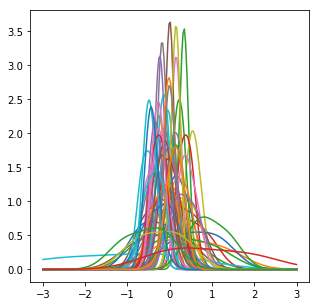

In [19]:
#indc = np.random.randint(low=0, high=normalized_power_spectrum.shape[0], size=(10000,))
samples_0 = normalized_power_spectrum[10000:10346, :]
samples_1 = normalized_phase_spectrum[10000:10346, :]
space_input = [samples_0, samples_1]
z_mu, z_logvar = icp_model.encode(space_input)
z = icp_model.reparametrize(z_mu, z_logvar)
z_np = z.numpy()

print(z_np.shape)

from scipy.stats import gaussian_kde
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for zdist in z_np.T:
    density = gaussian_kde(zdist)
    xs = np.linspace(-3, 3, 200)
    density.covariance_factor = lambda : .9
    density._compute_covariance()
    ax.plot(xs, density(xs))
    
plt.plot()

(173, 513) (173, 513)
(173, 513) (173, 513)
(513, 173) (513, 173)


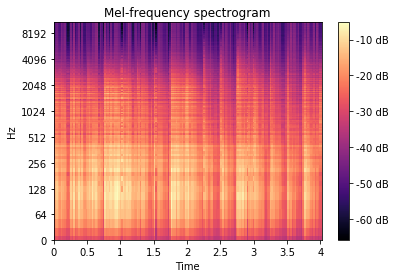

(513, 173)


In [22]:
def norm_db_to_power(S):
    S = np.clip(S, -1, 1)
    S_db = S * DBREF - DBREF
    S_pw = librosa.db_to_power(S_db)
    return (S_pw * WINSUM) * .5, S_db

k = 34
#k1 = 53
samps = int(np.ceil(DUR * SR / OVERLAP))

M_ = normalized_power_spectrum[k*samps:k*samps + samps, :]
#M_0 = normalized_power_spectrum[k1*samps:k1*samps + samps, :]
P_ = normalized_phase_spectrum[k*samps:k*samps + samps, :]
print(M_.shape, P_.shape)

Ms, MS_dB = norm_db_to_power(M_.T)

#P_t, _, _, _ = icp_model.predict(P_)
#print(S_t.shape)

model_input = [M_, M_]
z_mu, z_logvar = icp_model.encode(model_input)
z = icp_model.reparametrize(z_mu, z_logvar)

#model_input = [M_0, M_0]
#z_mu, z_logvar = icp_model.encode(model_input)
#z1 = icp_model.reparametrize(z_mu, z_logvar)

#z = 0.9*z0 + 0.1*z1

'''
z_mun = z_mu.numpy()
z_sig = tf.math.square(tf.math.exp(z_logvar)).numpy()
print(z_mun.shape, z_sig.shape)
mvg = []
for mu, sig in zip(z_mun, z_sig):
    sig_ = np.expand_dims(sig, 0)
    cov = sig_ * sig_.T
    samp = np.diag(np.random.multivariate_normal(mu, cov, size=(64, )))
    mvg.append(samp)
mvg = np.array(mvg)
'''

#zn = z.numpy()
#print(zn.max(), zn.min())

S_t, S_sd, P_t, P_sd = icp_model.decode(z)
print(S_t.shape, P_t.shape)

S, S_dB = norm_db_to_power(S_t.numpy().T)
P       = np.clip(P_.T, -1, 1) * np.pi
print(S.shape, P.shape)


#S, S_db = norm_db_to_power(normalized_power_spectrum[k*samps:k*samps + samps, :].T)
#S, S_db = norm_db_to_power(normalized_power_spectrum[0:100, :].T)
#S, S_db = norm_db_to_power(icp_model.predict(power_spectrum_timesteps[k*samps:k*samps + samps, :, :]).T)

#P_t = icp_model.predict(normalized_phase_spectrum[k*samps:k*samps + samps, :])
#P_t = icp_model.predict(phase_spectrum_timesteps[0:100, :, :])
#P_t = normalized_phase_spectrum[k*samps:k*samps + samps, :]
#print(P_t.min(), P_t.max())
#P = np.clip(P_t.T, -1, 1) * np.pi

fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='log', sr=SR, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

D0 = S*np.exp(1j*P)
print(D0.shape)

y_ = librosa.istft(stft_matrix = D0, 
                   hop_length  = OVERLAP, 
                   window      = FFTWIN)

import IPython.display as ipd
ipd.display(ipd.Audio(y_, rate=SR))

In [ ]:
'''
timedur_ms  = 100.
timedur_ss  = timedur_ms / 1000.
timesteps   = int(np.ceil(timedur_ss * SR / OVERLAP))
overlap     = timesteps // 2

# Reshape inputs into original "spectrums"
ORGDIM_TIME = int(np.ceil(DUR * SR / OVERLAP))
ORGDIM_FREQ = normalized_power_spectrum.shape[-1]

ax0 = (0, 0)
ax1 = (timesteps - 1, 0)
ax2 = (0, 0)

power_spectrum = normalized_power_spectrum.reshape(
    (-1, ORGDIM_TIME, ORGDIM_FREQ)
)
power_spectrum = np.pad(
    power_spectrum, [ax0, ax1, ax2], mode='constant'
)

phase_spectrum = normalized_phase_spectrum.reshape(
    (-1, ORGDIM_TIME, ORGDIM_FREQ)
)
phase_spectrum = np.pad(
    phase_spectrum, [ax0, ax1, ax2], mode='constant'
)

print(power_spectrum.shape, phase_spectrum.shape)

p = phase_spectrum.shape[0]
q = ORGDIM_TIME
r = timesteps
j = ORGDIM_FREQ

power_spectrum_timesteps = np.zeros((p, q, r, j))
phase_spectrum_timesteps = np.zeros((p, q, r, j))

def time_slices_for(arr):
    niters = ORGDIM_TIME
    slices = [arr[:, i:i+timesteps] for i in range(niters)]
    return np.array(slices)

for ix, spectrums in enumerate(zip(power_spectrum, phase_spectrum)):
    stft_arrs = np.array(spectrums)
    stft_slices = time_slices_for(stft_arrs)
    power_spectrum_timesteps[ix] = stft_slices[:, 0, :, :]
    phase_spectrum_timesteps[ix] = stft_slices[:, 1, :, :]

power_spectrum_timesteps = power_spectrum_timesteps.reshape((-1, r, j))
phase_spectrum_timesteps = phase_spectrum_timesteps.reshape((-1, r, j))
print(power_spectrum_timesteps.shape, phase_spectrum_timesteps.shape)

#print(194 // (timesteps - 1))    
#print(ORGDIM_TIME / (timesteps - overlap))
'''